# 12: Reinforcement learning (RL)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import mylib as my

**Reinforcement learning** is about making decisions based on experience. Here we have an agent that is trying to navigate an environment it does not know about. This agent can either fully or partially observe (see or sense) the environment. The agent's interaction with the environment is guided by the rewards (or punishments) it receives from the environment indicating wither it did good (or bad) at the end of the an episode. These rewards are the "reinforcement" in reinforcement learning (RL).

A common approach to navigating fully observable environments is the so-called **Markov Decision Process (MPD)** which will be the focus of this notebook. MDP is a stochastic process maintaining the Markov property. According to Wikipedia, "a stochastic process has the Markov property if the conditional probability distribution of future states of the process depends only upon the present state, not on the sequence of events that preceded it."

Because environments (states, transitions, and rewards) are different from one problem to another, MDP problems can look more different than they actually are.

We'll start with example MDP using the stochastic grid environment from the "Artificial Intelligence: A Modern Approach, 4th edition" book, which looks like this:

<img style="-webkit-user-select:none; display:block; margin:auto; padding:env(safe-area-inset-top) env(safe-area-inset-right) env(safe-area-inset-bottom) env(safe-area-inset-left);" src="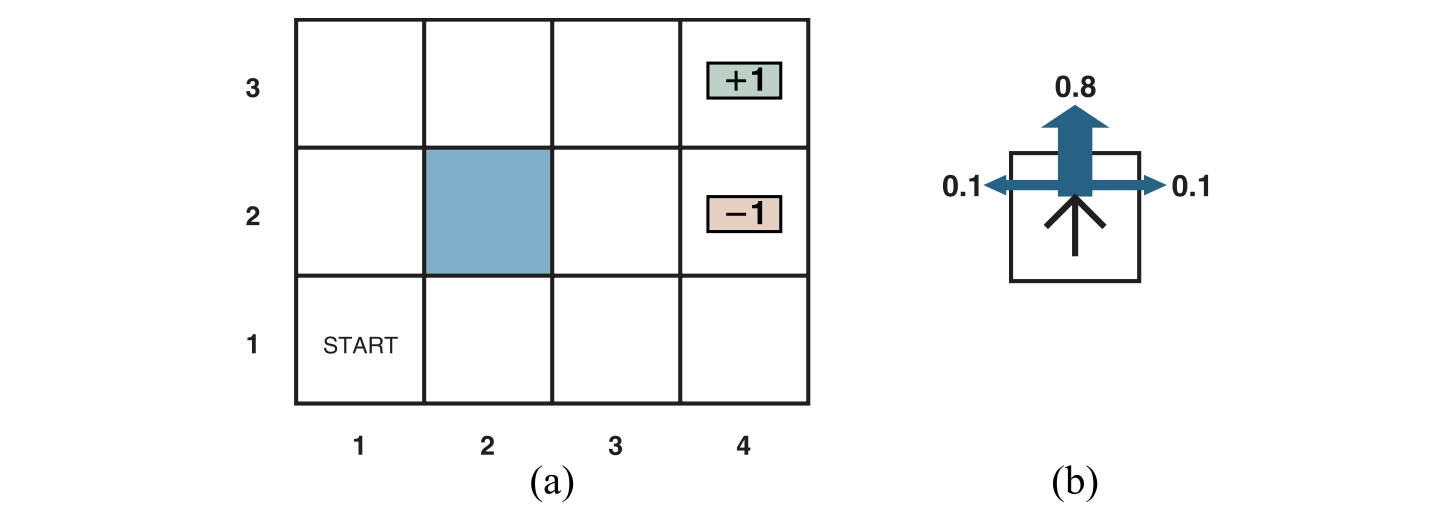">

You can think of each cell as a state. For example, the state `(1, 1)` is the start state. Each state has four possible actions: `<` (left),`^` (up), `>` (right), and `v` (down). Every one of these actions has a direction that takes the agent to a new state with 80% probability and to the states at the right angle sides of that direction with 10% probability each side. For example, if the agent is at state `(3, 1)`, then an `^` (up) action takes it to state `(3, 2)` with 80% probability, to state `(2, 1)` with 10% probability, and to state `(4, 1)` with 10% probability. A collision with the wall or with a blocked cell results in no movement.

The grid has one blocked cell at `(2, 2)` that the agent cannot get to. There are also two terminal states: a winning state `(4, 3)` with `+1` reward and a losing state `(4, 2)` with a `-1` punishment (negative reward). The process ends when the agent gets into either of these states.

Here is a class that represents this environment.

In [2]:
import numpy as np
import pandas as pd

class GridWorldMDP:
  def __init__(self, nCols, nRows, reward, blocked, probs, terminals):
    self.nCols = nCols
    self.nRows = nRows
    self.probs = {
      '<': {'v': probs['lhs'], '<': probs['forward'], '^': probs['rhs']}, 
      '^': {'<': probs['lhs'], '^': probs['forward'], '>': probs['rhs']}, 
      '>': {'^': probs['lhs'], '>': probs['forward'], 'v': probs['rhs']}, 
      'v': {'>': probs['lhs'], 'v': probs['forward'], '<': probs['rhs']}
    }
    self.blocked = blocked 
    self.terminals = terminals
    self.grid_ = {}
    self.rewards_ = {}

    self.__construct(reward)

  def __take_a_step(self, state, action):
    """
    a private method used in building the grid. This is where the destination
    of every action along its intented and at right angles directions are 
    specified.
    """
    col, row = state
    if state in self.blocked or state in self.terminals:
      to = state
    else: 
      if action == '^':
        u = -1 if row == self.nRows else row + 1
        to = (col, row if u == -1 else u)
      elif action == '<':
        l = -1 if col == 1 else col - 1
        to = (col if l == -1 else l, row)
      elif action == '>':
        r = -1 if col == self.nCols else col + 1
        to = (col if r == -1 else r, row)
      elif action == 'v':
        d = -1 if row == 1 else row - 1
        to = (col, row if d == -1 else d)

    if to in self.blocked:
      to = state

    rwd = self.rewards_[state]
    if to == state:
      rwd = 0.0

    if to in self.terminals:
      rwd = self.terminals[to]
    
    return to, rwd

  def __construct(self, reward):
    """
    a private method that builds the grid.
    """
    for i in range(self.nRows):
      for j in range(self.nCols):
        s =  (j + 1, self.nRows - i)
        blocked_or_terminal = s in self.terminals or s in self.blocked
        self.rewards_[s] = reward
        if s in self.blocked: self.rewards_[s] = -np.Inf
        if s in self.terminals: self.rewards_[s] = self.terminals[s]
        self.grid_[s] = {
          a: { 
            b: (*self.__take_a_step(s, b), (.0 if blocked_or_terminal else prob))  for b, prob in a_probs.items() 
           } for a, a_probs in self.probs.items()
        }

  def P(self, s, a, s_ = None):
    """
    returns the propbability of going from  state s to state s_ via action a.
    """
    a_probs = list(self.grid_[s][a].values())
    if s_ is None:
      return a_probs

    return sum([x[2] for x in a_probs if x[0] == s_])

  def R(self, s, a = None, s_ = None):
    """
    returns the reward of going from  state s to state s_ via action a.
    """
    if a is None or s_ is None:
      return self.rewards_[s]

    a_probs = list(self.grid_[s][a].values())
    return sum([x[1] for x in a_probs if x[0] == s_])

  def possible_actions(self):
        return list(self.grid_[(1, 1)].keys())
    
  def print_transitions(self):
    out = ""
    for s, s_actions in self.grid_.items():
      if s in self.blocked or s in self.terminals: continue
      out += f"{s}-"
      for a_, s_ in s_actions.items():
        out += f"\t{a_} :  {'; '.join(str(v) for v in s_.values())}\n"

    print(out)

  def print_in_grid(self, data):
    out = "---------------------------------------"
    for i in range(self.nRows):
      out += f"\n{(self.nRows - i):>2} |"
      for j in range(self.nCols):
        col, row =  j + 1, self.nRows - i
        if (col, row) in self.blocked:
          value = ' '
        elif (col, row) in self.terminals:
          value = str(self.rewards_[(col, row)])
        else:
          value = data[(col, row)]
        if isinstance(value, float):
          out += f"{value:>8.2f}"
        else:
          out += f"{value:>8}"
        
    print(out)
    print("---------------------------------------")
    print("    " + "".join([f"{(j + 1): 8}" for j in range(self.nCols)]))

This class takes multiple parameters describing the environment including:

* the rewards the agent gets when he gets into a state.
* the probabilities of moving through the grid
* the blocked and terminal states.


In [3]:
gw = GridWorldMDP(4, 3,
  reward= -0.04,
  probs= {"forward": .8, "lhs": .1, "rhs": .1},
  blocked= [ (2,2) ],
  terminals= {(4, 2): -1, (4, 3): +1 }
)

Let's print the reward system of this world:

In [4]:
gw.print_in_grid(gw.rewards_)

---------------------------------------
 3 |   -0.04   -0.04   -0.04       1
 2 |   -0.04           -0.04      -1
 1 |   -0.04   -0.04   -0.04   -0.04
---------------------------------------
           1       2       3       4


Here is also a printout of its transition model. Notice how the blocked and terminal states are not included in this printout, because blocked states are not actual states, and once you are in a terminal state, game is over.

In [5]:
gw.print_transitions()

(1, 3)-	< :  ((1, 2), -0.04, 0.1); ((1, 3), 0.0, 0.8); ((1, 3), 0.0, 0.1)
	^ :  ((1, 3), 0.0, 0.1); ((1, 3), 0.0, 0.8); ((2, 3), -0.04, 0.1)
	> :  ((1, 3), 0.0, 0.1); ((2, 3), -0.04, 0.8); ((1, 2), -0.04, 0.1)
	v :  ((2, 3), -0.04, 0.1); ((1, 2), -0.04, 0.8); ((1, 3), 0.0, 0.1)
(2, 3)-	< :  ((2, 3), 0.0, 0.1); ((1, 3), -0.04, 0.8); ((2, 3), 0.0, 0.1)
	^ :  ((1, 3), -0.04, 0.1); ((2, 3), 0.0, 0.8); ((3, 3), -0.04, 0.1)
	> :  ((2, 3), 0.0, 0.1); ((3, 3), -0.04, 0.8); ((2, 3), 0.0, 0.1)
	v :  ((3, 3), -0.04, 0.1); ((2, 3), 0.0, 0.8); ((1, 3), -0.04, 0.1)
(3, 3)-	< :  ((3, 2), -0.04, 0.1); ((2, 3), -0.04, 0.8); ((3, 3), 0.0, 0.1)
	^ :  ((2, 3), -0.04, 0.1); ((3, 3), 0.0, 0.8); ((4, 3), 1, 0.1)
	> :  ((3, 3), 0.0, 0.1); ((4, 3), 1, 0.8); ((3, 2), -0.04, 0.1)
	v :  ((4, 3), 1, 0.1); ((3, 2), -0.04, 0.8); ((2, 3), -0.04, 0.1)
(1, 2)-	< :  ((1, 1), -0.04, 0.1); ((1, 2), 0.0, 0.8); ((1, 3), -0.04, 0.1)
	^ :  ((1, 2), 0.0, 0.1); ((1, 3), -0.04, 0.8); ((1, 2), 0.0, 0.1)
	> :  ((1, 3), -0.04, 0.1)

## MDP algorithms
We now look at three algorithms that find optimal policies for this MDP environment. A policy is simply a mapping between states and action. An optimal policy $\pi^*$ is one that leads to maximum reward.

### Value iteration
This algorithm assigns each state a utility value that reflects the expected reward for the next action plus the discounted utility of the next state, assuming that the agent chooses the optimal action. The value of a state is defined as:

$$V(s) = max_{a} \Sigma_{s'} P(s, a, s') [R(s, a, s') + \gamma V(s')]$$

where:
* $P(s, a, s')$ is the transition probability from state $s$ to state $s'$ using action $a$. 
* $R(s, a, s')$ is the reward that the agent takes the action $a$ to go from state $s$ to state $s'$.
* $\gamma$ is the discount factor.

We can also define what is known as the **Q-function** $Q(s, a)$ which is the expected utility of taking action $a$ in state $s$. That is:

$$ Q(s, a) = \Sigma_{s'} P(s, a, s') [R(s, a, s') + \gamma V(s')]$s

Combining both of the above equations we get:

$$V(s) = max_{a} Q(s, a) $$

Here is a simple implementation of this function:

In [6]:
def q_function(mdp, s, a, V, gamma):
  S_a = list(mdp.grid_[s][a].values())
  return sum([p * (r + gamma * V[s_]) for (s_, r, p) in S_a])

def value_iteration(mdp, n_iter=50, epsilon=.001, gamma = 0.9):
  V_= { s : 0.0 for s, _ in mdp.grid_.items()}

  for _ in range(n_iter):
    V = V_.copy()
    for s, A_s in mdp.grid_.items():
      V_[s] = max([
        q_function(mdp, s, a, V, gamma) for a, _ in A_s.items()
      ])
       
  return V

Let's call this function and print $V(s)$ for every state.

In [7]:
gw.print_in_grid(value_iteration(gw, n_iter=100))

---------------------------------------
 3 |    0.63    0.78    0.93       1
 2 |    0.51            0.59      -1
 1 |    0.40    0.34    0.44    0.20
---------------------------------------
           1       2       3       4


To see what action should be taken at every state, we need to calculate the Q-function using the output of the previous `value_iteration` function. This is the optimal policy $\pi^*$ which is defined as:

$$\pi^*(s) = argmax_a\ Q(s, a)$$

In [8]:
Q = {} 
V = value_iteration(gw)
for s, A_s in gw.grid_.items():
  Q[s] = {}
  for a, S_a in A_s.items():
    Q[s][a] = q_function(gw, s, a, V, .9) 

gw.print_in_grid({ s: pd.Series(Q_a).idxmax() for s, Q_a in Q.items() })

---------------------------------------
 3 |       >       >       >       1
 2 |       ^               ^      -1
 1 |       ^       >       ^       <
---------------------------------------
           1       2       3       4


## Q-value iteration
The above `value_iteration` function gives us $V(s)$ values which are converted to Q-function values to get the optimal policy. We use the algorithm below to calculate q-function values directly.

In [9]:
def q_itreration(mdp, n_iter = 50, gamma=0.9):
    Q = {}
    for s, A_s in mdp.grid_.items():
        Q[s] = {}
        for a, S_a in A_s.items():
            Q[s][a] = 0.0  
            
    for _ in range(n_iter):
        q_prev = Q.copy()
        for s, A_s in mdp.grid_.items():
            for a, S_a in A_s.items():
                Q[s][a] = np.sum([
                    p * (mdp.R(s, a, s_) + gamma * max(q_prev[s_].values())) for _, (s_, r, p) in S_a.items() 
                ])
    
    return Q

In [10]:
Q = q_itreration(gw,n_iter=100)
gw.print_in_grid({ s: pd.Series(Q_a).idxmax() for s, Q_a in Q.items() })

---------------------------------------
 3 |       >       >       >       1
 2 |       ^               ^      -1
 1 |       ^       >       ^       <
---------------------------------------
           1       2       3       4


### Q-Learning
Q-learning is used when the agent does not know much about the environment, its rewards, and its transition model. Here we use dynamic programming to construct a table (more like a nested dictionary) called q-table that contains the Q-functions $Q(s, a)$, which reflects the quality of taking action $a$ in state $s$. 

To update $Q$ we use the update equation:

$$Q(s, a) = (1 - \eta) Q(s, a) + \eta (r + \gamma \max_{a'} Q(s', a'))$$

where $\eta$ is the learning rate, $\gamma$ is the discount factor, and $r$ is the reward of action $a$ at state $s$. 

To implement Q-learning for this problem, we define a function that explores this environment by randomly taking one of the possible actions given a state.

In [11]:
def explore(mdp, s):
    return np.random.choice([ a for a, S_a in mdp.grid_[s].items() if S_a[a][0] != s ])

We are now ready to implement the q-learning algorithm we talked about in class. In this function:
* We initialize the q-table to small random values.
* We then loop for `episodes` iterations. In each iteration, we:
    * pick a random non-terminal initial state $s$
    * As long as $s$ is not a terminal state (state F):
        * pick an action $a$ using the $\epsilon$-greedy strategy
        * get the reward based on state $s$ and action $a$
        * update $Q$
        
 Here is a simple implementation of this algorithm.

In [12]:
def q_learning(mdp, eta=0.7, gamma=0.9, epsilon=0.2, episodes=1000):
    # All valid states
    states = [s for s, _ in mdp.grid_.items() if s not in mdp.blocked]

    # Initialize the q-table to small random values
    Q = {}
    for s in states:
        Q[s] = {}
        for a, S_a in mdp.grid_[s].items():
            if S_a[a][0] != s or s in mdp.terminals:
                Q[s][a] = np.random.rand() * 0.1 - 0.05
                
    for _ in range(episodes):
        # Pick a non-terminal initial state
        while True:
            s = states[np.random.randint(len(states))]
            if s not in mdp.terminals: break 
        # Stop at the terminal state
        while s not in mdp.terminals:
            # epsilon-greedy
            if (np.random.rand() < epsilon):
                #print(s)
                a = explore(mdp, s)
            else:
                a = pd.Series(Q[s]).idxmax()

            s_ = mdp.grid_[s][a][a][0]
            r = mdp.R(s,a, s_)                 

            # The update rule
            Q[s][a] += eta * (r + gamma * max(Q[s_].values()) - Q[s][a])
            s = s_

    return Q

Let's run this algorithm and print out the returned policies:

In [13]:
Q = q_learning(gw, episodes=1000)
gw.print_in_grid({ s: pd.Series(Q_a).idxmax() for s, Q_a in Q.items()})

---------------------------------------
 3 |       >       >       >       1
 2 |       ^               ^      -1
 1 |       ^       >       ^       <
---------------------------------------
           1       2       3       4


## SARSA

Another slightly different algorithm is called SARSA which stands for State, Action, Reward, next State, next Action. This algorithm starts in the same way as the above q-learning function; it initializes the q-table. It then loops for `episodes` iterations. In each iteration, it:
* picks a random non-terminal initial state $s$
* picks an action $a$ from state $s$ using the $\epsilon$-greedy strategy
* As long as $s$ is not a terminal state (state F):
    * get the new state $s\_$ that results from taking action $a$ from state $s$ 
    * pick a new action $a\_$ from state $s\_$ using the $\epsilon$-greedy strategy
    * get the reward based on state $s\_$ and action $a\_$
    * update $Q$
        
Here is an implementation of this algorithm.

In [14]:
def sarsa(mdp, eta=0.7, gamma=0.9, epsilon=0.3, episodes=1000):
    # All valid states
    states = [s for s, _ in mdp.grid_.items() if s not in mdp.blocked]

    # Initialize the q-table to small random values
    Q = {}
    for s in states:
        Q[s] = {}
        for a, S_a in mdp.grid_[s].items():
            if S_a[a][0] != s or s in mdp.terminals:
                Q[s][a] = np.random.rand() * 0.1 - 0.05
                
    for _ in range(episodes):
        # Pick a non-terminal initial state
        while True:
            s = states[np.random.randint(len(states))]
            if s not in mdp.terminals: break 

        if (np.random.rand() < epsilon):
            a = explore(mdp, s)
        else:
            a = pd.Series(Q[s]).idxmax()

        # Stop at the terminal state
        while s not in mdp.terminals:
            s_ = mdp.grid_[s][a][a][0]
            r = mdp.R(s,a, s_)

            # epsilon-greedy
            if (np.random.rand() < epsilon):  
                if s_ in gw.terminals: # Avoid exploring an empty action list if s_ is terminal
                    actions = gw.possible_actions()
                    a_ = actions[np.random.randint(len(actions))]
                else:
                    a_ = explore(mdp, s_)
            else:
                a_ = pd.Series(Q[s_]).idxmax()

            Q[s][a] += eta * (r + gamma * Q[s_][a_] - Q[s][a])
            s = s_
            a = a_

    return Q

Let's run this algorithm and print out the returned policies:

In [15]:
Q = sarsa(gw, episodes=1000)
gw.print_in_grid({ s: pd.Series(Q_a).idxmax() for s, Q_a in Q.items()})

---------------------------------------
 3 |       >       >       >       1
 2 |       ^               ^      -1
 1 |       ^       <       ^       <
---------------------------------------
           1       2       3       4


## Another MDP example

Here have a simple graph from the textbook.

<img width="60%" src="data:image/svg+xml,%0A%3Csvg version='1.1' viewBox='0.0 0.0 742.2467191601049 334.01049868766404' fill='none' stroke='none' stroke-linecap='square' stroke-miterlimit='10' xmlns:xlink='http://www.w3.org/1999/xlink' xmlns='http://www.w3.org/2000/svg'%3E%3CclipPath id='p.0'%3E%3Cpath d='m0 0l742.2467 0l0 334.0105l-742.2467 0l0 -334.0105z' clip-rule='nonzero'/%3E%3C/clipPath%3E%3Cg clip-path='url(%23p.0)'%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m0 0l742.2467 0l0 334.0105l-742.2467 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m634.3027 54.82498l0 0c0 -28.570951 23.161316 -51.732285 51.7323 -51.732285l0 0c13.720215 0 26.87854 5.4503503 36.5802 15.152035c9.701721 9.701685 15.152039 22.859993 15.152039 36.58025l0 0c0 28.570953 -23.161316 51.732285 -51.73224 51.732285l0 0c-28.570984 0 -51.7323 -23.161331 -51.7323 -51.732285z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m634.3027 54.82498l0 0c0 -28.570951 23.161316 -51.732285 51.7323 -51.732285l0 0c13.720215 0 26.87854 5.4503503 36.5802 15.152035c9.701721 9.701685 15.152039 22.859993 15.152039 36.58025l0 0c0 28.570953 -23.161316 51.732285 -51.73224 51.732285l0 0c-28.570984 0 -51.7323 -23.161331 -51.7323 -51.732285z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m681.2819 61.744976l0 -13.359375l9.65625 0l0 1.578125l-7.875 0l0 4.09375l7.375 0l0 1.5625l-7.375 0l0 4.546875l8.1875 0l0 1.578125l-9.96875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m408.2318 179.2633l0 0c0 -28.570953 23.161316 -51.732285 51.73227 -51.732285l0 0c13.720276 0 26.87857 5.450348 36.58026 15.152039c9.701691 9.701675 15.152039 22.859985 15.152039 36.580246l0 0c0 28.570953 -23.161346 51.732285 -51.7323 51.732285l0 0c-28.570953 0 -51.73227 -23.161331 -51.73227 -51.732285z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m408.2318 179.2633l0 0c0 -28.570953 23.161316 -51.732285 51.73227 -51.732285l0 0c13.720276 0 26.87857 5.450348 36.58026 15.152039c9.701691 9.701675 15.152039 22.859985 15.152039 36.580246l0 0c0 28.570953 -23.161346 51.732285 -51.7323 51.732285l0 0c-28.570953 0 -51.73227 -23.161331 -51.73227 -51.732285z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m454.6651 186.1833l0 -13.359375l4.609375 0q1.546875 0 2.375 0.203125q1.140625 0.25 1.953125 0.953125q1.0625 0.890625 1.578125 2.28125q0.53125 1.390625 0.53125 3.171875q0 1.515625 -0.359375 2.703125q-0.359375 1.171875 -0.921875 1.9375q-0.546875 0.765625 -1.203125 1.21875q-0.65625 0.4375 -1.59375 0.671875q-0.9375 0.21875 -2.140625 0.21875l-4.828125 0zm1.765625 -1.578125l2.859375 0q1.3125 0 2.0625 -0.234375q0.75 -0.25 1.203125 -0.703125q0.625 -0.625 0.96875 -1.6875q0.359375 -1.0625 0.359375 -2.578125q0 -2.09375 -0.6875 -3.21875q-0.6875 -1.125 -1.671875 -1.5q-0.703125 -0.28125 -2.28125 -0.28125l-2.8125 0l0 10.203125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m3.0926976 179.2633l0 0c0 -28.570953 23.161333 -51.732285 51.732285 -51.732285l0 0c13.720253 0 26.878563 5.450348 36.580246 15.152039c9.701691 9.701675 15.152039 22.859985 15.152039 36.580246l0 0c0 28.570953 -23.161331 51.732285 -51.732285 51.732285l0 0c-28.570951 0 -51.732285 -23.161331 -51.732285 -51.732285z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m3.0926976 179.2633l0 0c0 -28.570953 23.161333 -51.732285 51.732285 -51.732285l0 0c13.720253 0 26.878563 5.450348 36.580246 15.152039c9.701691 9.701675 15.152039 22.859985 15.152039 36.580246l0 0c0 28.570953 -23.161331 51.732285 -51.732285 51.732285l0 0c-28.570951 0 -51.732285 -23.161331 -51.732285 -51.732285z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m48.571945 186.1833l5.124996 -13.359375l1.90625 0l5.46875 13.359375l-2.015625 0l-1.546875 -4.046875l-5.59375 0l-1.46875 4.046875l-1.8749962 0zm3.8593712 -5.484375l4.53125 0l-1.40625 -3.703125q-0.625 -1.6875 -0.9375 -2.765625q-0.265625 1.28125 -0.71875 2.546875l-1.46875 3.921875z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m195.91946 273.6019l0 0c0 -28.570969 23.161331 -51.7323 51.732285 -51.7323l0 0c13.720261 0 26.878555 5.450348 36.580246 15.152039c9.701691 9.701691 15.152039 22.859985 15.152039 36.58026l0 0c0 28.570923 -23.161316 51.73227 -51.732285 51.73227l0 0c-28.570953 0 -51.732285 -23.161346 -51.732285 -51.73227z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m195.91946 273.6019l0 0c0 -28.570969 23.161331 -51.7323 51.732285 -51.7323l0 0c13.720261 0 26.878555 5.450348 36.580246 15.152039c9.701691 9.701691 15.152039 22.859985 15.152039 36.58026l0 0c0 28.570923 -23.161316 51.73227 -51.732285 51.73227l0 0c-28.570953 0 -51.732285 -23.161346 -51.732285 -51.73227z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m251.88403 275.83438l1.765625 0.453125q-0.5625 2.171875 -2.0 3.328125q-1.4375 1.140625 -3.53125 1.140625q-2.15625 0 -3.515625 -0.875q-1.34375 -0.890625 -2.0625 -2.546875q-0.703125 -1.671875 -0.703125 -3.59375q0 -2.078125 0.796875 -3.625q0.796875 -1.5625 2.265625 -2.359375q1.484375 -0.8125 3.25 -0.8125q2.0 0 3.359375 1.015625q1.375 1.015625 1.90625 2.875l-1.734375 0.40625q-0.46875 -1.453125 -1.359375 -2.109375q-0.875 -0.671875 -2.203125 -0.671875q-1.546875 0 -2.578125 0.734375q-1.03125 0.734375 -1.453125 1.984375q-0.421875 1.234375 -0.421875 2.5625q0 1.703125 0.5 2.96875q0.5 1.265625 1.546875 1.90625q1.046875 0.625 2.265625 0.625q1.484375 0 2.515625 -0.859375q1.03125 -0.859375 1.390625 -2.546875z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m195.91946 54.82498l0 0c0 -28.570951 23.161331 -51.732285 51.732285 -51.732285l0 0c13.720261 0 26.878555 5.4503503 36.580246 15.152035c9.701691 9.701685 15.152039 22.859993 15.152039 36.58025l0 0c0 28.570953 -23.161316 51.732285 -51.732285 51.732285l0 0c-28.570953 0 -51.732285 -23.161331 -51.732285 -51.732285z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m195.91946 54.82498l0 0c0 -28.570951 23.161331 -51.732285 51.732285 -51.732285l0 0c13.720261 0 26.878555 5.4503503 36.580246 15.152035c9.701691 9.701685 15.152039 22.859993 15.152039 36.58025l0 0c0 28.570953 -23.161316 51.732285 -51.732285 51.732285l0 0c-28.570953 0 -51.732285 -23.161331 -51.732285 -51.732285z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m242.78934 61.744976l0 -13.359375l5.015625 0q1.53125 0 2.453125 0.40625q0.921875 0.40625 1.4375 1.25q0.53125 0.84375 0.53125 1.765625q0 0.859375 -0.46875 1.625q-0.453125 0.75 -1.390625 1.203125q1.203125 0.359375 1.859375 1.21875q0.65625 0.859375 0.65625 2.015625q0 0.9375 -0.40625 1.75q-0.390625 0.796875 -0.984375 1.234375q-0.578125 0.4375 -1.453125 0.671875q-0.875 0.21875 -2.15625 0.21875l-5.09375 0zm1.78125 -7.75l2.875 0q1.1875 0 1.6875 -0.140625q0.671875 -0.203125 1.015625 -0.671875q0.34375 -0.46875 0.34375 -1.171875q0 -0.65625 -0.328125 -1.15625q-0.3125 -0.515625 -0.90625 -0.703125q-0.59375 -0.1875 -2.03125 -0.1875l-2.65625 0l0 4.03125zm0 6.171875l3.3125 0q0.859375 0 1.203125 -0.0625q0.609375 -0.109375 1.015625 -0.359375q0.421875 -0.265625 0.6875 -0.75q0.265625 -0.484375 0.265625 -1.125q0 -0.75 -0.390625 -1.296875q-0.375 -0.546875 -1.0625 -0.765625q-0.671875 -0.234375 -1.953125 -0.234375l-3.078125 0l0 4.59375z' fill-rule='nonzero'/%3E%3Cpath fill='%23d9d9d9' d='m634.3027 273.6019l0 0c0 -28.570969 23.161316 -51.7323 51.7323 -51.7323l0 0c13.720215 0 26.87854 5.450348 36.5802 15.152039c9.701721 9.701691 15.152039 22.859985 15.152039 36.58026l0 0c0 28.570923 -23.161316 51.73227 -51.73224 51.73227l0 0c-28.570984 0 -51.7323 -23.161346 -51.7323 -51.73227z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m634.3027 273.6019l0 0c0 -28.570969 23.161316 -51.7323 51.7323 -51.7323l0 0c13.720215 0 26.87854 5.450348 36.5802 15.152039c9.701721 9.701691 15.152039 22.859985 15.152039 36.58026l0 0c0 28.570923 -23.161316 51.73227 -51.73224 51.73227l0 0c-28.570984 0 -51.7323 -23.161346 -51.7323 -51.73227z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m681.8682 280.52188l0 -13.359375l9.015625 0l0 1.578125l-7.25 0l0 4.140625l6.265625 0l0 1.578125l-6.265625 0l0 6.0625l-1.765625 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m91.40523 142.68306l104.50394 -87.84253' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m91.40523 142.68306l104.50394 -87.84253' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m284.232 237.02164l124.0 -57.76378' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m284.232 237.02164l124.0 -57.76378' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m299.38403 54.82498l124.0 87.842514' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m299.38403 54.82498l124.0 87.842514' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m496.54434 142.68306l152.91336 -51.275597' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m496.54434 142.68306l152.91336 -51.275597' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m299.38403 273.6019l334.92914 0' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m299.38403 273.6019l334.92914 0' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m686.035 106.55727l0 115.30708' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m686.035 106.55727l0 115.30708' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m247.65175 106.55727l0 115.30708' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m247.65175 106.55727l0 115.30708' fill-rule='evenodd'/%3E%3C/g%3E%3C/svg%3E">

In this example:
* We have six states (A through F) and F is the terminal state.
* The reward for staying at the same state is -5 (a punishment) except when you are at F. The reward for moving from a state to a non-terminal state is 0. The reward for getting to a terminal state (F) is 100. 
* In general, the number of actions at a given state is the same as the number of states. This means we have to option (if the environment allows it of course) to go to every other state or stay where it's at. either staying in the same state or moving to another. We can represent illegal transitions with a `-np.inf` (negative infinity) reward.
* The goal is to train an agent to navigate this graph (environment) and get to the terminal state F.

### Q-learning
We can use Q-learning to do this. In this example, the q-table will be $6 \times 6$. To update $Q$ we use the update equation (same as above):

$$Q(s, a) = (1 - \eta) Q(s, a) + \eta (r + \gamma \max_{a'} Q(s', a'))$$

where $\eta$ is the learning rate, $\gamma$ is the discount factor, and $r$ is the reward of action $a$ at state $s$. 

Let's implement Q-learning for this problem in a step by step manner. First we represent the environment graph using adjacency matrix like this:

In [16]:
T = np.array([
    [1,1,0,0,0,0],
    [1,1,1,1,0,0],
    [0,1,1,1,0,1],
    [0,1,1,1,1,0],
    [0,0,0,1,1,1],
    [0,0,1,0,1,1]])

Then we define the reward matrix:

In [17]:
R = np.array([
    [     -5,      0,-np.inf,-np.inf,-np.inf,-np.inf],
    [      0,     -5,      0,      0,-np.inf,-np.inf],
    [-np.inf,      0,     -5,      0,-np.inf,    100],
    [-np.inf,      0,      0,     -5,      0,-np.inf],
    [-np.inf,-np.inf,-np.inf,      0,     -5,    100],
    [-np.inf,-np.inf,      0,-np.inf,-np.inf,      0]])


Given these two matrices, we get

In [18]:
states = ['A', 'B', 'C', 'D', 'E', 'F']
n_states, n_actions = R.shape
print(f"No of states: {n_states}; No of actions: {n_actions}")

No of states: 6; No of actions: 6


We have some hyperparameters to initialize:

In [19]:
eta = 0.7
gamma = 0.4
epsilon = 0.1 # for e-greedy
episodes = 1000 # no of iterations

We can start the Q-learning algorithms by creating a q-table and initializing it to small random values.

In [20]:
Q = np.random.rand(n_states, n_actions) * 0.1 - 0.05

Using these values and without learning, here is what we get trying to get from A to F.

In [21]:
def print_path(Q, start_at):
    path = []
    s = start_at
    count = 0
    while s != 5:
        a = np.argmax(Q[s,:])
        path.append(states[s])
        path.append(f"--{R[s,a]}->")
        # For this example, new state is the chosen action
        s = a
        count += 1
        if count > len(Q):
            print("Path too long...")
            break
            
    path.append(states[s])
    print(''.join(path))
    
print_path(Q, 0)

Path too long...
A---inf->C---inf->E---5.0->E---5.0->E---5.0->E---5.0->E---5.0->E


which is not even a valid path. Let's learn then.

We now loop for `episodes` iterations. In each iteration, we:
* pick a random random state $s$
* As long as $s$ is not a terminal state (state F):
    * pick an action $a$ using the $\epsilon$-greedy strategy
    * get the reward based on state $s$ and action $a$
    * update $Q$

In [22]:
for _ in range(episodes):
    # Pick initial state
    s = np.random.randint(n_states)
    
    # Stop at the terminal state
    while s != 5:
        # epsilon-greedy
        if (np.random.rand()<epsilon):
            indices = np.where(T[s,:]!=0)
            pick = np.random.randint(np.shape(indices)[1])
            a = indices[0][pick]
        else:
            a = np.argmax(Q[s,:])

        r = R[s,a]
        # For this example, new state is the chosen action
        s_prime = a

        Q[s,a] += eta * (r + gamma * np.max(Q[s_prime,:]) - Q[s,a])
        s = s_prime
        
print(f"Finished {episodes} training episodes.")

Finished 1000 training episodes.


Here is the q-table (rounded to 2 decimal points) we got from the algorithm below:

In [23]:
print(Q.round())

[[  1.  16. -inf -inf  -0.  -0.]
 [  6.  11.  40.  16.  -0.  -0.]
 [-inf  16.  35.  16. -inf 100.]
 [-inf  16.  40.  11.  40.  -0.]
 [ -0.  -0.   0.  16.  35. 100.]
 [ -0.   0.   0.   0.  -0.  -0.]]


To test this we can now use this q-table to navigate the environment. Assume that our starting state is A.

In [24]:
print_path(Q, 0)

A--0.0->B--0.0->C--100.0->F


### SARSA

Let's also implement the SARSA (State, Action, Reward, next State, next Action) algorithm described above. We start by initializing the q-table to random small values.

In [25]:
Q = np.random.rand(n_states,n_actions) * 0.1 - 0.05

Again using this table without learning gives us the following path:

In [26]:
print_path(Q, 0)

Path too long...
A---inf->E---5.0->E---5.0->E---5.0->E---5.0->E---5.0->E---5.0->E


which also is not a valid path. Now we use the SARSA algorithm to learn how to navigate this graph.

In [27]:
episodes = 1000
for _ in range(episodes):
    # Pick initial state
    s = np.random.randint(n_states)
    # Pick action epsilon-greedy
    if (np.random.rand() < epsilon):
        indices = np.where(T[s,:]!=0)
        pick = np.random.randint(np.shape(indices)[1])
        a = indices[0][pick]
    else:
        a = np.argmax(Q[s,:])

    # Stop at the terminal state
    while s != 5:
        r = R[s,a]
        # For this example, new state is the chosen action
        s_prime = a

        # Pick action prime
        if (np.random.rand() < epsilon):
            indices = np.where(T[s_prime,:]!=0)
            pick = np.random.randint(np.shape(indices)[1])
            a_prime = indices[0][pick]
        else:
            a_prime = np.argmax(Q[s_prime,:])

        Q[s,a] += eta * (r + gamma * Q[s_prime,a_prime] - Q[s,a])

        s = s_prime
        a = a_prime
        
print(f"Finished {episodes} training episodes.")

Finished 1000 training episodes.


Now that we've learned, let print the path from A to F:

In [28]:
print_path(Q, 0)

A--0.0->B--0.0->C--100.0->F


Which algorithm (Q-Learning or SARSA) runs faster?

## Yet another example: Using Gym
The hardest part about working RL is specifying the environment. In the simple examples above, we had to think about how to represent states, actions, and transitions, as you saw in the Grid example, that implementation can quickly get complicated. For more complex problems, this could be too much work. 

To help with that, there is a package called `gym` from [OpenAI](https://gym.openai.com/) which comes with multiple environments that you can use for RL. To install it, use the command:

```
conda activate ml
conda install -c conda-forge gym
```

Here we use a simple self driving-cab example. The goal of this cab is to pick up the passenger at one location and drop them off in another. 

Here is what the environment looks like:

In [29]:
import gym

env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



This is a $5 \times 5$ grid; Think of it as a parking lot. The cab (the yellow block) can pick up passengers from four locations (R, G, Y, B). The passengers can be in 5 locations (in the cab or in one of the pickup locations). The combination of the grid, pickup, and drop-off locations gives us a state space of $5 \times 5 \times 4 \times 5 = 500$ states. A state is then represented by 4-tuple:
* row (0 - 4)
* column (0 - 4)
* passenger index (0-4): 0-3 for the 4 destinations and 4 for the passenger being inside the cab
* destination index (0-3)


The action spaces has six possible actions (0-5): south, north, east, west, pickup, and drop-off.

The solid `|` represent walls preventing the cap from performing certain actions.

We can move the cab to any state by doing something like this:

In [30]:
state = env.encode(4, 0, 4, 0) # (row, column, passenger index (0-4), destination index (0-3))
env.s = state
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Play with these numbers. Notice that the cab color changes from yellow to green when the passenger is in the cap (passenger index 4) 

In [31]:
state = env.encode(3, 2, 4, 0) # (row, column, passenger index (0-4), destination index (0-3))
env.s = state
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | :_| : |
|Y| : |B: |
+---------+



The reward table for can be obtained by `env.P`. For example, the reward at the current environment state is:

In [32]:
env.P[env.s]

{0: [(1.0, 456, -1, False)],
 1: [(1.0, 256, -1, False)],
 2: [(1.0, 356, -1, False)],
 3: [(1.0, 336, -1, False)],
 4: [(1.0, 356, -10, False)],
 5: [(1.0, 356, -10, False)]}

The rewards are structured as follows `(probability, nextstate, reward, done)` such that:

* 0-5 corresponds to the actions (south, north, east, west, pickup, drop-off).
* In this environment, probability is always 1.0.
* `nextstate` determines where the cab will be if that action is taken.
* The rewards are as follows:
    * -10 for pickup/drop-off
    * 20 for being at the drop-off state with passenger inside
    * -1 for all other movements.
    
Now that we have a better idea of how this environment works, we can start implementing the Q-learning algorithm. 

We define the q-table and initialize it to small random numbers.

In [33]:
Q = np.random.rand(env.observation_space.n, env.action_space.n) * 0.1 - 0.05

Let's evaluate how bad these initial values by running 100 episodes and reporting the pickup/drop-off penalties encountered.

In [34]:
def penalty_per_episode(episodes = 100):
    total_itrs, total_penalties = 0, 0

    for _ in range(episodes):
        s = env.reset()
        itr, penalties, r = 0, 0, 0

        done = False
        while not done:
            s, r, done, info = env.step(np.argmax(Q[s,:]))

            if r == -10:
                penalties += 1

            itr += 1
            if(itr > len(Q)): # to avoid getting stuck
                break

        total_penalties += penalties
        total_itrs += itr

    return total_penalties / episodes

In [35]:
print(f"Ran {100} episodes")
print(f"Penalty per episode: {penalty_per_episode(100)}")

Ran 100 episodes
Penalty per episode: 285.03


We now train the agent using the Q-learning algorithm.

In [36]:
eta = 0.1
gamma = 0.6
epsilon = 0.1
episodes = 100000

for _ in range(episodes):
    s = env.reset()

    done = False
    while not done:
        # epsilon-greedy
        if (np.random.rand()<epsilon):
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s, :])
            
        s_prime, r, done, info = env.step(a) 
        
        Q[s,a] += eta * (r + gamma * np.max(Q[s_prime,:]) - Q[s,a])

        s = s_prime
        
print(f"Finished {episodes} training episodes.")

Finished 100000 training episodes.


We can now evaluate the agent by 

In [37]:
print(f"Ran {100} episodes")
print(f"Penalty per episode: {penalty_per_episode(100)}")

Ran 100 episodes
Penalty per episode: 0.0


### CHALLENGE (Optional)
Train the above cab agent using the SARSA algorithm. Test your work.

In [38]:
# TODO